# Project: Wrangling and Analyze Data

## Data Gathering
In the cell below, gather **all** three pieces of data for this project and load them in the notebook. **Note:** the methods required to gather each data are different.
1. Directly download the WeRateDogs Twitter archive data (twitter_archive_enhanced.csv)

In [1]:
# import some packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# read The WeRateDogs Twitter archive data into a pandas dataframe
twitter_df = pd.read_csv('twitter-archive-enhanced.csv')
twitter_df

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None
5,891087950875897856,NaN,NaN,2017-07-29 00:08:17 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a majestic great white breaching ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891087950...,13,10,None,None,None,None,None
6,890971913173991426,NaN,NaN,2017-07-28 16:27:12 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Jax. He enjoys ice cream so much he gets ...,NaN,NaN,NaN,"https://gofundme.com/ydvmve-surgery-for-jax,ht...",13,10,Jax,None,None,None,None
7,890729181411237888,NaN,NaN,2017-07-28 00:22:40 +0000,"<a href=""http://twitter.com/download/iphone"" r...",When you watch your owner call another dog a g...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890729181...,13,10,None,None,None,None,None
8,890609185150312448,NaN,NaN,2017-07-27 16:25:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Zoey. She doesn't want to be one of th...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890609185...,13,10,Zoey,None,None,None,None
9,890240255349198849,NaN,NaN,2017-07-26 15:59:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Cassie. She is a college pup. Studying...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890240255...,14,10,Cassie,doggo,None,None,None


In [3]:
twitter_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

2. Use the Requests library to download the tweet image prediction (image_predictions.tsv)

In [4]:
# get image-predictions.tsv file
import requests
url = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'
img = requests.get(url)
img

<Response [200]>

In [5]:
# read image_predictions.tsv data into a pandas dataframe
import io
img_df = pd.read_csv(io.StringIO(img.content.decode('utf-8')), sep='\t')
img_df

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True
5,666050758794694657,https://pbs.twimg.com/media/CT5Jof1WUAEuVxN.jpg,1,Bernese_mountain_dog,0.651137,True,English_springer,0.263788,True,Greater_Swiss_Mountain_dog,0.016199,True
6,666051853826850816,https://pbs.twimg.com/media/CT5KoJ1WoAAJash.jpg,1,box_turtle,0.933012,False,mud_turtle,0.045885,False,terrapin,0.017885,False
7,666055525042405380,https://pbs.twimg.com/media/CT5N9tpXIAAifs1.jpg,1,chow,0.692517,True,Tibetan_mastiff,0.058279,True,fur_coat,0.054449,False
8,666057090499244032,https://pbs.twimg.com/media/CT5PY90WoAAQGLo.jpg,1,shopping_cart,0.962465,False,shopping_basket,0.014594,False,golden_retriever,0.007959,True
9,666058600524156928,https://pbs.twimg.com/media/CT5Qw94XAAA_2dP.jpg,1,miniature_poodle,0.201493,True,komondor,0.192305,True,soft-coated_wheaten_terrier,0.082086,True


In [6]:
img_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


3. Use the Tweepy library to query additional data via the Twitter API (tweet_json.txt)

In [7]:
# get tweet-json.txt file
import json
tweet = []
for line in open('tweet-json.txt', 'r'):
    tweet.append(json.loads(line))

In [8]:
# read tweet-json.txt file into a pandas dataframe with tweet ID, retweet count and favorite count
tweet_df = pd.DataFrame.from_dict(tweet)
tweet_df = tweet_df[['id', 'retweet_count', 'favorite_count']]
tweet_df

,id,retweet_count,favorite_count
0,892420643555336193,8853,39467
1,892177421306343426,6514,33819
2,891815181378084864,4328,25461
3,891689557279858688,8964,42908
4,891327558926688256,9774,41048
5,891087950875897856,3261,20562
6,890971913173991426,2158,12041
7,890729181411237888,16716,56848
8,890609185150312448,4429,28226
9,890240255349198849,7711,32467


In [9]:
tweet_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2354 entries, 0 to 2353
Data columns (total 3 columns):
id                2354 non-null int64
retweet_count     2354 non-null int64
favorite_count    2354 non-null int64
dtypes: int64(3)
memory usage: 55.2 KB


In [10]:
# check the columns that being contained among variables
all_columns = pd.Series(list(twitter_df) + list(img_df) + list(tweet_df))
all_columns[all_columns.duplicated()]

17    tweet_id
dtype: object

## Assessing Data
In this section, detect and document at least **eight (8) quality issues and two (2) tidiness issue**. You must use **both** visual assessment
programmatic assessement to assess the data.

**Note:** pay attention to the following key points when you access the data.

* You only want original ratings (no retweets) that have images. Though there are 5000+ tweets in the dataset, not all are dog ratings and some are retweets.
* Assessing and cleaning the entire dataset completely would require a lot of time, and is not necessary to practice and demonstrate your skills in data wrangling. Therefore, the requirements of this project are only to assess and clean at least 8 quality issues and at least 2 tidiness issues in this dataset.
* The fact that the rating numerators are greater than the denominators does not need to be cleaned. This [unique rating system](http://knowyourmeme.com/memes/theyre-good-dogs-brent) is a big part of the popularity of WeRateDogs.
* You do not need to gather the tweets beyond August 1st, 2017. You can, but note that you won't be able to gather the image predictions for these tweets since you don't have access to the algorithm used.



### Quality issues
#### `twitter_df` table

1. tweets are retweets

2. tweets are reply of tweets

3. columns named in_reply_to_status_id, in_reply_to_user_id, retweeted_status_id, retweeted_status_user_id, retweeted_status_timestamp contain NaN value mostly. columns named source, text, expanded_urls are not really useful to analysis.

4. timestamp is a string not a datetime

5. name column contains inaccurate value 

#### `img_df` table

6. p1, p2, p3 values are unconsistent between capitaled or uncapitaled

7. number of records is less than number of records in twitter_df and tweet_df tables

8. columns named jpg_url and img_num are not useful to analysis anymore

### Tidiness issues
1. `img_df` and `tweet_df` should be part of `twitter_df`

2. pivot 4 columns in `twitter_df` into 1 column

## Cleaning Data
In this section, clean **all** of the issues you documented while assessing. 

**Note:** Make a copy of the original data before cleaning. Cleaning includes merging individual pieces of data according to the rules of [tidy data](https://cran.r-project.org/web/packages/tidyr/vignettes/tidy-data.html). The result should be a high-quality and tidy master pandas DataFrame (or DataFrames, if appropriate).

In [11]:
# Make copies of original pieces of data
twitter = twitter_df.copy()
img = img_df.copy()
tweet = tweet_df.copy()

### Issue #1: `img_df` and `tweet_df` should be part of `twitter_df`

#### Define
Merge 3 data frames into 1 and drop duplicated column named id

#### Code

In [12]:
# use merge function to join 3 tables
df = twitter.merge(img, on = 'tweet_id', how = 'left').merge(tweet, left_on = 'tweet_id', right_on = 'id', how = 'left')
df = df.drop(['id'],axis=1)

#### Test

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2356 entries, 0 to 2355
Data columns (total 30 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
jpg_url                       20

### Issue #2: `twitter_df` tweets are retweets

#### Define
Drop records that tweets are retweets

#### Code

In [14]:
# get all records that have retweeted_status_id is null
df = df[df.retweeted_status_id.isnull()]

#### Test

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2175 entries, 0 to 2355
Data columns (total 30 columns):
tweet_id                      2175 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2175 non-null object
source                        2175 non-null object
text                          2175 non-null object
retweeted_status_id           0 non-null float64
retweeted_status_user_id      0 non-null float64
retweeted_status_timestamp    0 non-null object
expanded_urls                 2117 non-null object
rating_numerator              2175 non-null int64
rating_denominator            2175 non-null int64
name                          2175 non-null object
doggo                         2175 non-null object
floofer                       2175 non-null object
pupper                        2175 non-null object
puppo                         2175 non-null object
jpg_url                       1994 non

### Issue #3: `twitter_df` tweets are reply of tweets

#### Define
Drop records that tweets are reply of tweets

#### Code

In [16]:
# get all records that have in_reply_to_status_id is null
df = df[df.in_reply_to_status_id.isnull()]
df.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,...,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,retweet_count,favorite_count
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,...,0.097049,False,bagel,0.085851,False,banana,0.076110,False,8853.0,39467.0
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,...,0.323581,True,Pekinese,0.090647,True,papillon,0.068957,True,6514.0,33819.0
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,...,0.716012,True,malamute,0.078253,True,kelpie,0.031379,True,4328.0,25461.0
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,...,0.170278,False,Labrador_retriever,0.168086,True,spatula,0.040836,False,8964.0,42908.0
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,...,0.555712,True,English_springer,0.225770,True,German_short-haired_pointer,0.175219,True,9774.0,41048.0


#### Test

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2097 entries, 0 to 2355
Data columns (total 30 columns):
tweet_id                      2097 non-null int64
in_reply_to_status_id         0 non-null float64
in_reply_to_user_id           0 non-null float64
timestamp                     2097 non-null object
source                        2097 non-null object
text                          2097 non-null object
retweeted_status_id           0 non-null float64
retweeted_status_user_id      0 non-null float64
retweeted_status_timestamp    0 non-null object
expanded_urls                 2094 non-null object
rating_numerator              2097 non-null int64
rating_denominator            2097 non-null int64
name                          2097 non-null object
doggo                         2097 non-null object
floofer                       2097 non-null object
pupper                        2097 non-null object
puppo                         2097 non-null object
jpg_url                       1971 non-n

### Issue #4: `twitter_df` columns named in_reply_to_status_id, in_reply_to_user_id, retweeted_status_id, retweeted_status_user_id, retweeted_status_timestamp contain NaN value mostly. columns named source, text, expanded_urls are not really useful to analysis.

#### Define: 
Remove in_reply_to_status_id, in_reply_to_user_id, retweeted_status_id, retweeted_status_user_id, retweeted_status_timestamp, source, text, expanded_urls from dataframe

#### Code

In [18]:
df = df.drop(['in_reply_to_status_id', 'in_reply_to_user_id', 'retweeted_status_id', 'retweeted_status_user_id', 'retweeted_status_timestamp', 'source', 'text', 'expanded_urls'], axis=1)

#### Test

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2097 entries, 0 to 2355
Data columns (total 22 columns):
tweet_id              2097 non-null int64
timestamp             2097 non-null object
rating_numerator      2097 non-null int64
rating_denominator    2097 non-null int64
name                  2097 non-null object
doggo                 2097 non-null object
floofer               2097 non-null object
pupper                2097 non-null object
puppo                 2097 non-null object
jpg_url               1971 non-null object
img_num               1971 non-null float64
p1                    1971 non-null object
p1_conf               1971 non-null float64
p1_dog                1971 non-null object
p2                    1971 non-null object
p2_conf               1971 non-null float64
p2_dog                1971 non-null object
p3                    1971 non-null object
p3_conf               1971 non-null float64
p3_dog                1971 non-null object
retweet_count         2097 non-n

### Issue #5: `twitter_df` timestamp is a string not a datetime

#### Define
Change timestamp to datetime datatype

#### Code

In [20]:
df.timestamp = pd.to_datetime(df.timestamp)

#### Test

In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2097 entries, 0 to 2355
Data columns (total 22 columns):
tweet_id              2097 non-null int64
timestamp             2097 non-null datetime64[ns]
rating_numerator      2097 non-null int64
rating_denominator    2097 non-null int64
name                  2097 non-null object
doggo                 2097 non-null object
floofer               2097 non-null object
pupper                2097 non-null object
puppo                 2097 non-null object
jpg_url               1971 non-null object
img_num               1971 non-null float64
p1                    1971 non-null object
p1_conf               1971 non-null float64
p1_dog                1971 non-null object
p2                    1971 non-null object
p2_conf               1971 non-null float64
p2_dog                1971 non-null object
p3                    1971 non-null object
p3_conf               1971 non-null float64
p3_dog                1971 non-null object
retweet_count         20

### Issue #6: `img_df` number of records is less than number of records in twitter_df and tweet_df tables

#### Define
Remove records that jpg_url is null

#### Code

In [22]:
df = df[df.jpg_url.notnull()]

#### Test

In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1971 entries, 0 to 2355
Data columns (total 22 columns):
tweet_id              1971 non-null int64
timestamp             1971 non-null datetime64[ns]
rating_numerator      1971 non-null int64
rating_denominator    1971 non-null int64
name                  1971 non-null object
doggo                 1971 non-null object
floofer               1971 non-null object
pupper                1971 non-null object
puppo                 1971 non-null object
jpg_url               1971 non-null object
img_num               1971 non-null float64
p1                    1971 non-null object
p1_conf               1971 non-null float64
p1_dog                1971 non-null object
p2                    1971 non-null object
p2_conf               1971 non-null float64
p2_dog                1971 non-null object
p3                    1971 non-null object
p3_conf               1971 non-null float64
p3_dog                1971 non-null object
retweet_count         19

### Issue #7: `img_df` columns named jpg_url and img_num are not useful to analysis anymore.

#### Define
Remove jpg_url, img_num from dataframe

#### Code

In [24]:
df = df.drop(['jpg_url', 'img_num'], axis=1)

#### Test

In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1971 entries, 0 to 2355
Data columns (total 20 columns):
tweet_id              1971 non-null int64
timestamp             1971 non-null datetime64[ns]
rating_numerator      1971 non-null int64
rating_denominator    1971 non-null int64
name                  1971 non-null object
doggo                 1971 non-null object
floofer               1971 non-null object
pupper                1971 non-null object
puppo                 1971 non-null object
p1                    1971 non-null object
p1_conf               1971 non-null float64
p1_dog                1971 non-null object
p2                    1971 non-null object
p2_conf               1971 non-null float64
p2_dog                1971 non-null object
p3                    1971 non-null object
p3_conf               1971 non-null float64
p3_dog                1971 non-null object
retweet_count         1971 non-null float64
favorite_count        1971 non-null float64
dtypes: datetime64[ns](

### Issue #8: `img_df` p1, p2, p3 values are unconsistent between capitaled or uncapitaled

#### Define
Uncapitalize all the p1,p2,p3 value and remove underscore

#### Code

In [26]:
df.p1 = df.p1.str.replace('_',' ').str.lower()
df.p2 = df.p2.str.replace('_',' ').str.lower()
df.p3 = df.p3.str.replace('_',' ').str.lower()

#### Test

In [27]:
df[['p1', 'p2', 'p3']].head()

,p1,p2,p3
0,orange,bagel,banana
1,chihuahua,pekinese,papillon
2,chihuahua,malamute,kelpie
3,paper towel,labrador retriever,spatula
4,basset,english springer,german short-haired pointer


### Issue #9: pivot 4 columns in `twitter_df` into 1 column

#### Define
Pivot 4 columns named doggo, floofer, pupper, puppo in to column named type and drop those 4 columns in the dataframe

#### Code

In [28]:
df["type"] = df.apply(lambda x: (((None if x.puppo == 'None' else x.puppo) if x.pupper == 'None' else x.pupper) if x.floofer == 'None' else x.floofer) if x.doggo == 'None' else x.doggo, axis=1)
df = df.drop(['doggo', 'floofer', 'pupper', 'puppo'], axis = 1)

#### Test

In [29]:
df.type

0         None
1         None
2         None
3         None
4         None
5         None
6         None
7         None
8         None
9        doggo
10        None
11        None
12       puppo
13        None
14       puppo
15        None
16        None
17        None
18        None
20        None
21        None
22        None
23        None
24        None
25        None
26        None
27        None
28        None
29      pupper
31        None
         ...  
2326      None
2327      None
2328      None
2329      None
2330      None
2331      None
2332      None
2333      None
2334      None
2335      None
2336      None
2337      None
2338      None
2339      None
2340      None
2341      None
2342      None
2343      None
2344      None
2345      None
2346      None
2347      None
2348      None
2349      None
2350      None
2351      None
2352      None
2353      None
2354      None
2355      None
Name: type, Length: 1971, dtype: object

### Issue #10: `twitter_df` name column contains inaccurate value

#### Define
Fill inaccurate values to None 

#### Code

In [30]:
df.name

0        Phineas
1          Tilly
2         Archie
3          Darla
4       Franklin
5           None
6            Jax
7           None
8           Zoey
9         Cassie
10          Koda
11         Bruno
12          None
13           Ted
14        Stuart
15        Oliver
16           Jim
17          Zeke
18       Ralphus
20        Gerald
21       Jeffrey
22          such
23        Canela
24          None
25          None
26          Maya
27        Mingus
28         Derek
29        Roscoe
31       Waffles
          ...   
2326       quite
2327           a
2328        None
2329        None
2330        None
2331        None
2332        None
2333          an
2334           a
2335          an
2336        None
2337        None
2338        None
2339        None
2340        None
2341        None
2342        None
2343        None
2344        None
2345         the
2346         the
2347           a
2348           a
2349          an
2350           a
2351        None
2352           a
2353          

In [31]:
df['name'].str.islower().sum()

98

In [32]:
df['name'].mask(df['name'].str.islower(), None, inplace=True)

#### Test

In [33]:
df['name'].str.islower().sum()

0

## Storing Data
Save gathered, assessed, and cleaned master dataset to a CSV file named "twitter_archive_master.csv".

In [34]:
df.to_csv('twitter_archive_master.csv')

## Analyzing and Visualizing Data
In this section, analyze and visualize your wrangled data. You must produce at least **three (3) insights and one (1) visualization.**

In [35]:
# review data on dataframe
df

,tweet_id,timestamp,rating_numerator,rating_denominator,name,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,retweet_count,favorite_count,type
0,892420643555336193,2017-08-01 16:23:56,13,10,Phineas,orange,0.097049,False,bagel,0.085851,False,banana,0.076110,False,8853.0,39467.0,None
1,892177421306343426,2017-08-01 00:17:27,13,10,Tilly,chihuahua,0.323581,True,pekinese,0.090647,True,papillon,0.068957,True,6514.0,33819.0,None
2,891815181378084864,2017-07-31 00:18:03,12,10,Archie,chihuahua,0.716012,True,malamute,0.078253,True,kelpie,0.031379,True,4328.0,25461.0,None
3,891689557279858688,2017-07-30 15:58:51,13,10,Darla,paper towel,0.170278,False,labrador retriever,0.168086,True,spatula,0.040836,False,8964.0,42908.0,None
4,891327558926688256,2017-07-29 16:00:24,12,10,Franklin,basset,0.555712,True,english springer,0.225770,True,german short-haired pointer,0.175219,True,9774.0,41048.0,None
5,891087950875897856,2017-07-29 00:08:17,13,10,None,chesapeake bay retriever,0.425595,True,irish terrier,0.116317,True,indian elephant,0.076902,False,3261.0,20562.0,None
6,890971913173991426,2017-07-28 16:27:12,13,10,Jax,appenzeller,0.341703,True,border collie,0.199287,True,ice lolly,0.193548,False,2158.0,12041.0,None
7,890729181411237888,2017-07-28 00:22:40,13,10,None,pomeranian,0.566142,True,eskimo dog,0.178406,True,pembroke,0.076507,True,16716.0,56848.0,None
8,890609185150312448,2017-07-27 16:25:51,13,10,Zoey,irish terrier,0.487574,True,irish setter,0.193054,True,chesapeake bay retriever,0.118184,True,4429.0,28226.0,None
9,890240255349198849,2017-07-26 15:59:51,14,10,Cassie,pembroke,0.511319,True,cardigan,0.451038,True,chihuahua,0.029248,True,7711.0,32467.0,doggo


In [36]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1971 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id              1971 non-null int64
timestamp             1971 non-null datetime64[ns]
rating_numerator      1971 non-null int64
rating_denominator    1971 non-null int64
name                  1873 non-null object
p1                    1971 non-null object
p1_conf               1971 non-null float64
p1_dog                1971 non-null object
p2                    1971 non-null object
p2_conf               1971 non-null float64
p2_dog                1971 non-null object
p3                    1971 non-null object
p3_conf               1971 non-null float64
p3_dog                1971 non-null object
retweet_count         1971 non-null float64
favorite_count        1971 non-null float64
type                  303 non-null object
dtypes: datetime64[ns](1), float64(5), int64(3), object(8)
memory usage: 277.2+ KB


In [37]:
# sort sum of favorite count by type of dog
df.groupby('type')['favorite_count'].sum().sort_values()

type
floofer      92442.0
puppo       474806.0
doggo      1390224.0
pupper     1457356.0
Name: favorite_count, dtype: float64

In [38]:
# sort sum of retweet count by type of dog
df.groupby('type')['retweet_count'].sum().sort_values()

type
floofer     34781.0
puppo      142427.0
pupper     478883.0
doggo      506726.0
Name: retweet_count, dtype: float64

In [39]:
# the tweet id and name and type of dog that have highest favourite count
max_favorite_count = df.query('favorite_count == favorite_count.max()')
print(max_favorite_count[['tweet_id', 'name', 'type']])

# the tweet id and name and type of dog that have highest retweet count
max_retweet_count = df.query('retweet_count == retweet_count.max()')
print(max_retweet_count[['tweet_id', 'name', 'type']])

               tweet_id  name   type
413  822872901745569793  None  puppo
                tweet_id  name   type
1039  744234799360020481  None  doggo


### Insights:
1. The most favorite type of dog is pupper that got 1457356 times. Doggo is the second one and going after are puppo then  floofer. 

2. On the other hand, doggo is the most popular dog that got highest retweet count. While pupper got 478883 times of retweet, floofer is the fewest retweet count if comparing to 3 other types of dog.

3. The tweet_id 822872901745569793 is a puppo that got highest favorite count and the tweet_id 744234799360020481 is a doggo that got highest retweet count.

### Visualization

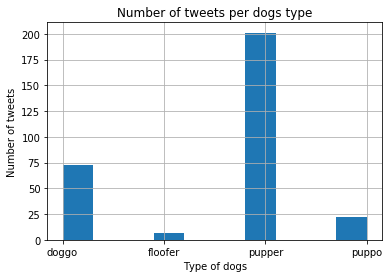

In [45]:
df[df.type.isin(['pupper', 'doggo', 'puppo', 'floofer'])].type.hist()
plt.xlabel('Type of dogs')
plt.ylabel('Number of tweets')
plt.title('Number of tweets per dogs type')
plt.show();

As can be seen from the chart above, the number of tweets decreased from pupper, doggo, puppo then floofer.